In [423]:
# Python 3.9.18
# Numpy : 1.26.0
# Pandas : 2.1.1
# Matplotlib : 3.7.2
# Seaborn : 0.12.2
# Scikit-learn : 1.3.0
# Created: OCT. 25. 2023
# Author: D.W. SHIN
# 2023 전력사용량 예측 AI 경진대회
# 알고리즘 | 정형 | 시계열 | 에너지 | SMAPE
# [Baseline] Random Forest을 기본으로 사용함

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import platform

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, SGDRegressor, ARDRegression, GammaRegressor, PoissonRegressor, TweedieRegressor, HuberRegressor, QuantileRegressor, RANSACRegressor, ridge_regression, TheilSenRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor, AdaBoostRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

In [424]:
sysOS = platform.system()

if sysOS == 'Windows':
    # Windows 일 경우
    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
elif sysOS == 'Darwin':
    # Mac일 경우
    plt.rcParams['font.family'] ='AppleGothic'
    plt.rcParams['axes.unicode_minus'] = False
else:
    print('Please check your Korean font!!')
    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf
    print('#' * 30)
    print('#' * 30)
    print('런타임을 다시 시작해 주세요~~~')
    print('#' * 30)
    print('#' * 30)

## Fixed Random-Seed

In [425]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [426]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
building_df = pd.read_csv('../data/building_info.csv')

In [427]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [428]:
train_df.tail()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08
203999,100_20220824 23,100,20220824 23,20.7,NaN,0.1,95.0,NaN,NaN,540.24


In [429]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [430]:
building_df.tail()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-
99,100,호텔및리조트,57497.84,40035.23,-,-,-


## Train Data Pre-Processing

### 날짜 컬럼 생성

In [431]:
#'일시' 컬럼을 날짜 컬럼으로 추가
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['YEAR'] = train_df['일시'].dt.year
train_df['MONTH'] = train_df['일시'].dt.month
train_df['DAY'] = train_df['일시'].dt.day
train_df['DATE'] = train_df['일시'].dt.date
train_df['HOUR'] = train_df['일시'].dt.hour
train_df['WEEKDAY'] = train_df['일시'].dt.weekday

### 결측치 처리

In [432]:
# 결측값이 있는지 확인
train_df.isna().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
YEAR                  0
MONTH                 0
DAY                   0
DATE                  0
HOUR                  0
WEEKDAY               0
dtype: int64

In [433]:
# 강수량(mm)의 결측치는 너무 많아서 0으로 처리 함
train_df['강수량(mm)'].fillna(0, inplace=True)

In [434]:
# 풍속(m/s)의 결측치를 확인
train_df[train_df['풍속(m/s)'].isnull()]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,DATE,HOUR,WEEKDAY
16643,9_20220614 11,9,2022-06-14 11:00:00,17.6,0.0,NaN,NaN,NaN,NaN,2330.40,2022,6,14,2022-06-14,11,1
30161,15_20220806 17,15,2022-08-06 17:00:00,35.6,0.0,NaN,NaN,NaN,NaN,1815.57,2022,8,6,2022-08-06,17,5
32127,16_20220803 15,16,2022-08-03 15:00:00,30.4,0.0,NaN,77.0,0.5,2.06,5062.08,2022,8,3,2022-08-03,15,2
51640,26_20220627 16,26,2022-06-27 16:00:00,27.2,3.1,NaN,93.0,0.0,0.27,5330.40,2022,6,27,2022-06-27,16,0
51921,26_20220709 09,26,2022-07-09 09:00:00,26.3,0.0,NaN,84.0,0.0,0.81,2908.80,2022,7,9,2022-07-09,9,5
84418,42_20220703 10,42,2022-07-03 10:00:00,29.8,0.0,NaN,66.0,1.0,2.61,3038.76,2022,7,3,2022-07-03,10,6
100738,50_20220703 10,50,2022-07-03 10:00:00,29.8,0.0,NaN,66.0,1.0,2.61,3044.70,2022,7,3,2022-07-03,10,6
105639,52_20220806 15,52,2022-08-06 15:00:00,33.4,0.0,NaN,72.0,0.0,NaN,2260.20,2022,8,6,2022-08-06,15,5
105640,52_20220806 16,52,2022-08-06 16:00:00,33.5,0.0,NaN,73.0,0.0,NaN,2274.30,2022,8,6,2022-08-06,16,5
176477,87_20220714 05,87,2022-07-14 05:00:00,21.9,0.0,NaN,NaN,NaN,NaN,519.66,2022,7,14,2022-07-14,5,3


In [435]:
# 샘플 조건 테스트
train_df[(train_df['건물번호'] == 9) & (train_df['MONTH'] == 6) & (train_df['HOUR'] == 11)]['풍속(m/s)'].describe()['mean']

2.9413793103448276

In [436]:
# 풍속의 결측치를 건물의 동일 시간의 한달 평균으로 채워 넣는다.
for i in train_df[train_df['풍속(m/s)'].isnull()].index:
    bld_num = train_df.iloc[i]['건물번호']
    year = train_df.iloc[i]['YEAR']
    month = train_df.iloc[i]['MONTH']
    hour = train_df.iloc[i]['HOUR']
    mean_data = train_df[(train_df['건물번호'] == bld_num) & (train_df['YEAR'] == year) & (train_df['MONTH'] == month) & (train_df['HOUR'] == hour)]['풍속(m/s)'].describe()['mean']
    train_df.loc[i, '풍속(m/s)'] = (0 if np.isnan(mean_data) else mean_data)
    print(train_df.loc[i, '풍속(m/s)'])

2.9413793103448276
2.1130434782608694
2.2782608695652176
2.0758620689655167
1.0800000000000003
1.6566666666666665
1.6566666666666665
4.569565217391304
4.621739130434783
0.4499999999999999
0.28666666666666674
0.4033333333333334
0.6599999999999999
0.63
2.1130434782608694
4.569565217391304
4.621739130434783
2.4793103448275864
0.41


In [437]:
train_df['풍속(m/s)'].isna().sum()

0

In [438]:
# 습도의 결측치도 동일하게 처리 한다
for i in train_df[train_df['습도(%)'].isnull()].index:
    bld_num = train_df.iloc[i]['건물번호']
    year = train_df.iloc[i]['YEAR']
    month = train_df.iloc[i]['MONTH']
    hour = train_df.iloc[i]['HOUR']
    mean_data = train_df[(train_df['건물번호'] == bld_num) & (train_df['YEAR'] == year) & ( train_df['MONTH'] == month) & (train_df['HOUR'] == hour)]['습도(%)'].describe()['mean']
    train_df.loc[i, '습도(%)'] = (0 if np.isnan(mean_data) else mean_data)
    print(train_df.loc[i, '습도(%)'])

66.55172413793103
71.30434782608695
95.63333333333334
95.7
94.33333333333333
90.4
85.53333333333333
71.30434782608695
61.58620689655172


In [439]:
# 일조(hr)와 일사(MJ/m2)의 결측치를 0 으로 처리함
train_df['일조(hr)'].fillna(0, inplace=True)
train_df['일사(MJ/m2)'].fillna(0, inplace=True)

In [440]:
train_df.isnull().sum()

num_date_time    0
건물번호             0
일시               0
기온(C)            0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
YEAR             0
MONTH            0
DAY              0
DATE             0
HOUR             0
WEEKDAY          0
dtype: int64

#### building info에서 결측치 '-'를 0으로 변경 후 컬럼의 속성을 float로 변경하는 방법 : 

##### 1. 느린방법

In [441]:
# 결측치가 '-' 를 확인
# building_df.isin(['-']).sum()

In [442]:
# 결측치 '-'를 0으로 채움
# building_df.replace('-', 0, inplace=True)

In [443]:
# building_df.isin(['-']).sum()

In [444]:
# 아래 컬럼의 속성을 float로 변환
# building_df['태양광용량(kW)'] = building_df['태양광용량(kW)'].astype(float)
# building_df['ESS저장용량(kWh)'] = building_df['ESS저장용량(kWh)'].astype(float)
# building_df['PCS용량(kW)'] = building_df['PCS용량(kW)'].astype(float)

In [445]:
# building_df.info()

##### 2. 빠른방법

In [446]:
cols = ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']
for col in cols:
    building_df[col] = building_df[col].apply(lambda x : 0 if x =='-' else float(x))

In [447]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    float64
 5   ESS저장용량(kWh)  100 non-null    float64
 6   PCS용량(kW)     100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


### 필요 컬럼 생성

#### 불쾌 지수 생성
- 0.81 * 섭씨온도 +0.01 * 상대습도(%)（0.99*섭씨온도 - 14.3）+ 46.3


In [448]:
train_df['DI'] = 0.81 * train_df['기온(C)'] + 0.01 * train_df['습도(%)'] * (0.99 * train_df['기온(C)'] - 14.3) + 46.3

In [449]:
train_df['DI_CAT'] = pd.cut(train_df['DI'], bins=[0, 68, 78, 80, 100], include_lowest=True, labels=['GOOD', 'NOMAL', 'BAD', 'VERY_BAD'])

In [450]:
train_df.tail()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,DATE,HOUR,WEEKDAY,DI,DI_CAT
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,0.5,0.0,881.04,2022,8,24,2022-08-24,19,2,72.38034,NOMAL
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,0.0,0.0,798.96,2022,8,24,2022-08-24,20,2,71.21736,NOMAL
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,0.0,0.0,825.12,2022,8,24,2022-08-24,21,2,69.79704,NOMAL
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,0.0,0.0,640.08,2022,8,24,2022-08-24,22,2,69.41060,NOMAL
203999,100_20220824 23,100,2022-08-24 23:00:00,20.7,0.0,0.1,95.0,0.0,0.0,540.24,2022,8,24,2022-08-24,23,2,68.95035,NOMAL


### DF 합치기

In [451]:
# building_df을 train_df으로 데이터 프레임 합치기
train_df = pd.merge(train_df, building_df, how='left',on='건물번호')

In [452]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   건물번호           204000 non-null  int64         
 2   일시             204000 non-null  datetime64[ns]
 3   기온(C)          204000 non-null  float64       
 4   강수량(mm)        204000 non-null  float64       
 5   풍속(m/s)        204000 non-null  float64       
 6   습도(%)          204000 non-null  float64       
 7   일조(hr)         204000 non-null  float64       
 8   일사(MJ/m2)      204000 non-null  float64       
 9   전력소비량(kWh)     204000 non-null  float64       
 10  YEAR           204000 non-null  int32         
 11  MONTH          204000 non-null  int32         
 12  DAY            204000 non-null  int32         
 13  DATE           204000 non-null  object        
 14  HOUR           204000 non-null  int32         
 15  

### 컬럼 삭제

In [453]:
# 생성된 컬럼 중 분석에 필요하지 않은 컬럼 제거
train_df.drop(['num_date_time'], axis=1, inplace=True)

## 데이터 분석하기

In [454]:
# 건물유형에 따른 전력소비량 확인하기
train_df.groupby('건물유형')['전력소비량(kWh)'].sum().sort_values(ascending=False)

건물유형
대학교        8.908494e+07
건물기타       6.033480e+07
데이터센터      5.504836e+07
병원         4.753673e+07
연구소        4.583898e+07
상용         3.752580e+07
백화점및아울렛    3.694639e+07
지식산업센터     3.158805e+07
공공         2.748253e+07
호텔및리조트     2.415473e+07
할인마트       2.310724e+07
아파트        2.136289e+07
Name: 전력소비량(kWh), dtype: float64

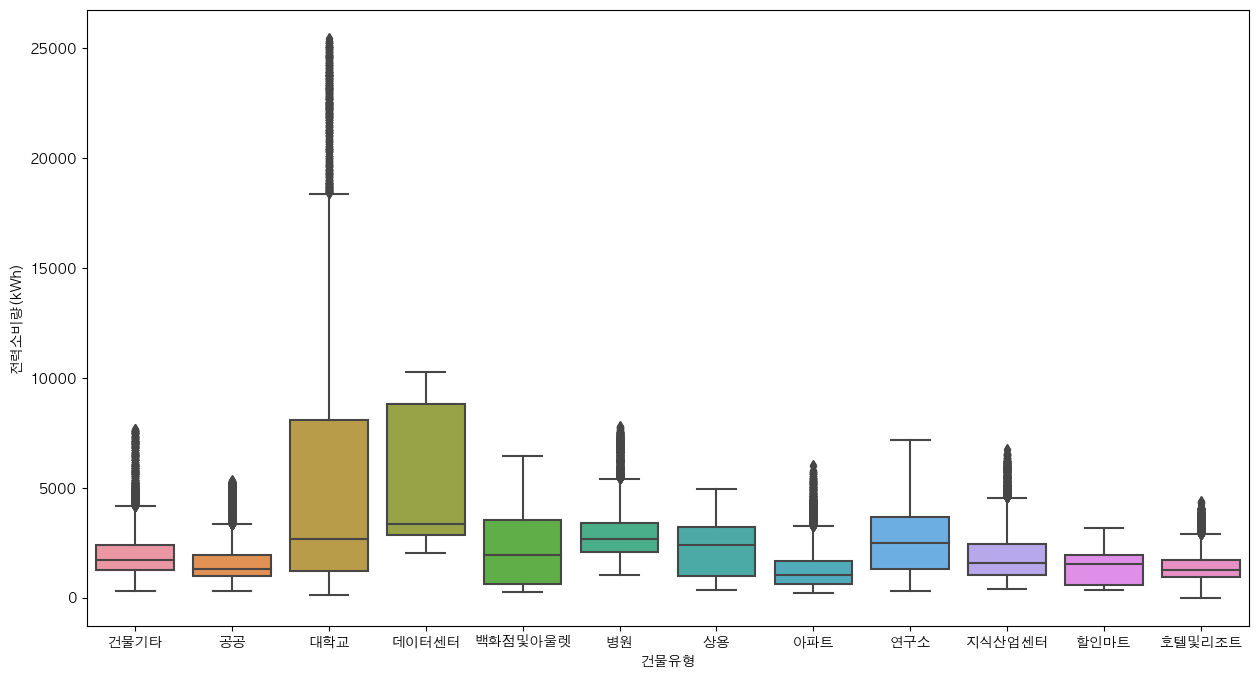

In [455]:
# 건물유형에 따른 전력소비량 그래프로 확인하기
plt.figure(figsize=(15,8))
sns.boxplot(x='건물유형', y='전력소비량(kWh)', data=train_df)
plt.show()

In [456]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   건물번호          204000 non-null  int64         
 1   일시            204000 non-null  datetime64[ns]
 2   기온(C)         204000 non-null  float64       
 3   강수량(mm)       204000 non-null  float64       
 4   풍속(m/s)       204000 non-null  float64       
 5   습도(%)         204000 non-null  float64       
 6   일조(hr)        204000 non-null  float64       
 7   일사(MJ/m2)     204000 non-null  float64       
 8   전력소비량(kWh)    204000 non-null  float64       
 9   YEAR          204000 non-null  int32         
 10  MONTH         204000 non-null  int32         
 11  DAY           204000 non-null  int32         
 12  DATE          204000 non-null  object        
 13  HOUR          204000 non-null  int32         
 14  WEEKDAY       204000 non-null  int32         
 15  DI            204

### 레이블 작업 하기

In [457]:
# 레이블링 작업
le = LabelEncoder()
train_df['DI_CAT'] = le.fit_transform(train_df['DI_CAT'])

### 건물 유형별 corr 확인

In [460]:
#각 건물유형 별 corr 확인하기
building_infos = ['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트']

result_list = []
for index, building_info in enumerate(building_infos):
    result_df = train_df[train_df['건물유형'] == building_info]
    result_df = result_df.drop(['일시', 'DATE', 'HOUR', 'WEEKDAY', '건물유형'], axis=1)
    result_list.append(result_df.corr())


In [461]:
result_list[0]

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,DI,DI_CAT,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
건물번호,1.000000e+00,-0.044685,-0.034128,0.070718,0.073842,0.057470,0.014788,0.085173,NaN,-1.678595e-15,-1.273482e-15,-0.031802,0.011599,-3.980688e-01,-2.489342e-01,2.416289e-01,-1.996885e-01,-1.994865e-01
기온(C),-4.468540e-02,1.000000,-0.067495,0.164529,-0.388944,0.411565,0.437953,0.236235,NaN,4.401239e-01,6.105114e-02,0.954349,0.290086,1.089286e-01,9.288398e-02,-3.712625e-02,2.061766e-02,2.063386e-02
강수량(mm),-3.412773e-02,-0.067495,1.000000,0.035707,0.211258,-0.099540,-0.099320,-0.022185,NaN,4.378098e-02,2.341450e-02,-0.011958,-0.018113,1.933512e-03,-1.142700e-03,1.118214e-02,1.594836e-02,1.576888e-02
풍속(m/s),7.071759e-02,0.164529,0.035707,1.000000,-0.148925,0.165810,0.258928,0.282337,NaN,-8.901267e-02,1.030575e-01,0.138733,0.021272,-1.140874e-01,-4.962691e-02,-2.103089e-01,-1.179977e-02,-1.127392e-02
습도(%),7.384228e-02,-0.388944,0.211258,-0.148925,1.000000,-0.570216,-0.538709,-0.058778,NaN,2.508874e-01,1.286686e-01,-0.112090,-0.119454,-1.198948e-01,-1.022028e-01,4.073954e-02,-3.865692e-02,-3.842351e-02
일조(hr),5.746998e-02,0.411565,-0.099540,0.165810,-0.570216,1.000000,0.769990,0.162756,NaN,-4.269712e-02,-8.050035e-02,0.251010,0.146094,-2.226028e-02,-1.105285e-02,-2.197288e-02,-1.463602e-02,-1.494935e-02
일사(MJ/m2),1.478834e-02,0.437953,-0.099320,0.258928,-0.538709,0.769990,1.000000,0.267865,NaN,-2.824903e-02,-5.700345e-02,0.289907,0.158537,4.170282e-02,5.003451e-02,-1.563174e-01,1.543940e-02,1.523294e-02
전력소비량(kWh),8.517255e-02,0.236235,-0.022185,0.282337,-0.058778,0.162756,0.267865,1.000000,NaN,1.023041e-01,2.540153e-02,0.234367,0.082375,-5.280004e-02,-4.198280e-02,-9.594718e-02,9.675470e-02,1.008478e-01
YEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONTH,-1.678595e-15,0.440124,0.043781,-0.089013,0.250887,-0.042697,-0.028249,0.102304,NaN,1.000000e+00,-1.333186e-01,0.564412,0.120827,8.714730e-15,5.987568e-15,-4.067124e-15,1.090872e-14,1.126334e-14


In [463]:
result_list[0].iloc[:, 7]

건물번호            0.085173
기온(C)           0.236235
강수량(mm)        -0.022185
풍속(m/s)         0.282337
습도(%)          -0.058778
일조(hr)          0.162756
일사(MJ/m2)       0.267865
전력소비량(kWh)      1.000000
YEAR                 NaN
MONTH           0.102304
DAY             0.025402
DI              0.234367
DI_CAT          0.082375
연면적(m2)        -0.052800
냉방면적(m2)       -0.041983
태양광용량(kW)      -0.095947
ESS저장용량(kWh)    0.096755
PCS용량(kW)       0.100848
Name: 전력소비량(kWh), dtype: float64

In [465]:
# corr 리스트로 담기
corr_list = []
for index, building_info in enumerate(building_infos):
    corr_list.append(result_list[index].iloc[:, 7])

In [466]:
corr_list[0]

건물번호            0.085173
기온(C)           0.236235
강수량(mm)        -0.022185
풍속(m/s)         0.282337
습도(%)          -0.058778
일조(hr)          0.162756
일사(MJ/m2)       0.267865
전력소비량(kWh)      1.000000
YEAR                 NaN
MONTH           0.102304
DAY             0.025402
DI              0.234367
DI_CAT          0.082375
연면적(m2)        -0.052800
냉방면적(m2)       -0.041983
태양광용량(kW)      -0.095947
ESS저장용량(kWh)    0.096755
PCS용량(kW)       0.100848
Name: 전력소비량(kWh), dtype: float64

In [467]:
# DF 만들기
corr_df = pd.DataFrame(corr_list)

In [468]:
corr_df

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,DI,DI_CAT,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
전력소비량(kWh),0.085173,0.236235,-0.022185,0.282337,-0.058778,0.162756,0.267865,1.0,NaN,0.102304,0.025402,0.234367,0.082375,-0.052800,-0.041983,-0.095947,0.096755,0.100848
전력소비량(kWh),-0.305826,0.250507,-0.001584,0.078046,-0.121128,0.244346,0.297578,1.0,NaN,0.104267,0.023530,0.233102,0.071059,0.022561,0.017164,-0.025099,-0.023879,0.012287
전력소비량(kWh),-0.542149,0.200199,0.035565,0.183219,-0.163403,0.037689,0.242598,1.0,NaN,0.049060,0.006769,0.168492,0.038931,0.810922,0.872589,0.099215,NaN,NaN
전력소비량(kWh),-0.899177,0.045193,-0.008693,0.044887,0.000324,-0.022131,0.001634,1.0,NaN,0.022013,0.005233,0.050753,-0.004456,0.988651,0.879894,NaN,NaN,NaN
전력소비량(kWh),-0.139707,0.526836,0.029966,0.334299,-0.439241,0.436299,0.601612,1.0,NaN,0.073232,0.006869,0.435559,0.175663,0.161694,0.153810,0.247372,NaN,NaN
전력소비량(kWh),-0.221211,0.228532,0.061036,0.104671,-0.143888,0.202967,0.266376,1.0,NaN,0.149368,0.032439,0.200134,0.095103,0.805026,0.788468,-0.443685,NaN,NaN
전력소비량(kWh),0.197969,0.223891,0.041128,0.075400,-0.248643,0.212702,0.294823,1.0,NaN,0.078418,0.020810,0.151267,0.044536,-0.049436,-0.101601,0.124870,NaN,NaN
전력소비량(kWh),-0.247537,0.238030,0.051554,0.157841,-0.087768,0.006074,0.009963,1.0,NaN,0.163134,-0.010399,0.231778,0.052541,0.800428,0.642104,NaN,NaN,NaN
전력소비량(kWh),-0.492828,0.168468,0.072895,0.266985,-0.183352,0.081990,0.229473,1.0,NaN,0.089790,0.028544,0.119814,0.032403,0.640413,0.764188,0.210097,-0.154890,-0.154890
전력소비량(kWh),-0.054054,0.369746,0.008839,0.268062,-0.208197,0.335092,0.494492,1.0,NaN,0.120975,0.027796,0.321204,0.116438,0.334479,0.036095,NaN,NaN,NaN


In [469]:
corr_df.index = ['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트']

In [470]:
corr_df

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,DI,DI_CAT,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
건물기타,0.085173,0.236235,-0.022185,0.282337,-0.058778,0.162756,0.267865,1.0,NaN,0.102304,0.025402,0.234367,0.082375,-0.052800,-0.041983,-0.095947,0.096755,0.100848
공공,-0.305826,0.250507,-0.001584,0.078046,-0.121128,0.244346,0.297578,1.0,NaN,0.104267,0.023530,0.233102,0.071059,0.022561,0.017164,-0.025099,-0.023879,0.012287
대학교,-0.542149,0.200199,0.035565,0.183219,-0.163403,0.037689,0.242598,1.0,NaN,0.049060,0.006769,0.168492,0.038931,0.810922,0.872589,0.099215,NaN,NaN
데이터센터,-0.899177,0.045193,-0.008693,0.044887,0.000324,-0.022131,0.001634,1.0,NaN,0.022013,0.005233,0.050753,-0.004456,0.988651,0.879894,NaN,NaN,NaN
백화점및아울렛,-0.139707,0.526836,0.029966,0.334299,-0.439241,0.436299,0.601612,1.0,NaN,0.073232,0.006869,0.435559,0.175663,0.161694,0.153810,0.247372,NaN,NaN
병원,-0.221211,0.228532,0.061036,0.104671,-0.143888,0.202967,0.266376,1.0,NaN,0.149368,0.032439,0.200134,0.095103,0.805026,0.788468,-0.443685,NaN,NaN
상용,0.197969,0.223891,0.041128,0.075400,-0.248643,0.212702,0.294823,1.0,NaN,0.078418,0.020810,0.151267,0.044536,-0.049436,-0.101601,0.124870,NaN,NaN
아파트,-0.247537,0.238030,0.051554,0.157841,-0.087768,0.006074,0.009963,1.0,NaN,0.163134,-0.010399,0.231778,0.052541,0.800428,0.642104,NaN,NaN,NaN
연구소,-0.492828,0.168468,0.072895,0.266985,-0.183352,0.081990,0.229473,1.0,NaN,0.089790,0.028544,0.119814,0.032403,0.640413,0.764188,0.210097,-0.154890,-0.154890
지식산업센터,-0.054054,0.369746,0.008839,0.268062,-0.208197,0.335092,0.494492,1.0,NaN,0.120975,0.027796,0.321204,0.116438,0.334479,0.036095,NaN,NaN,NaN


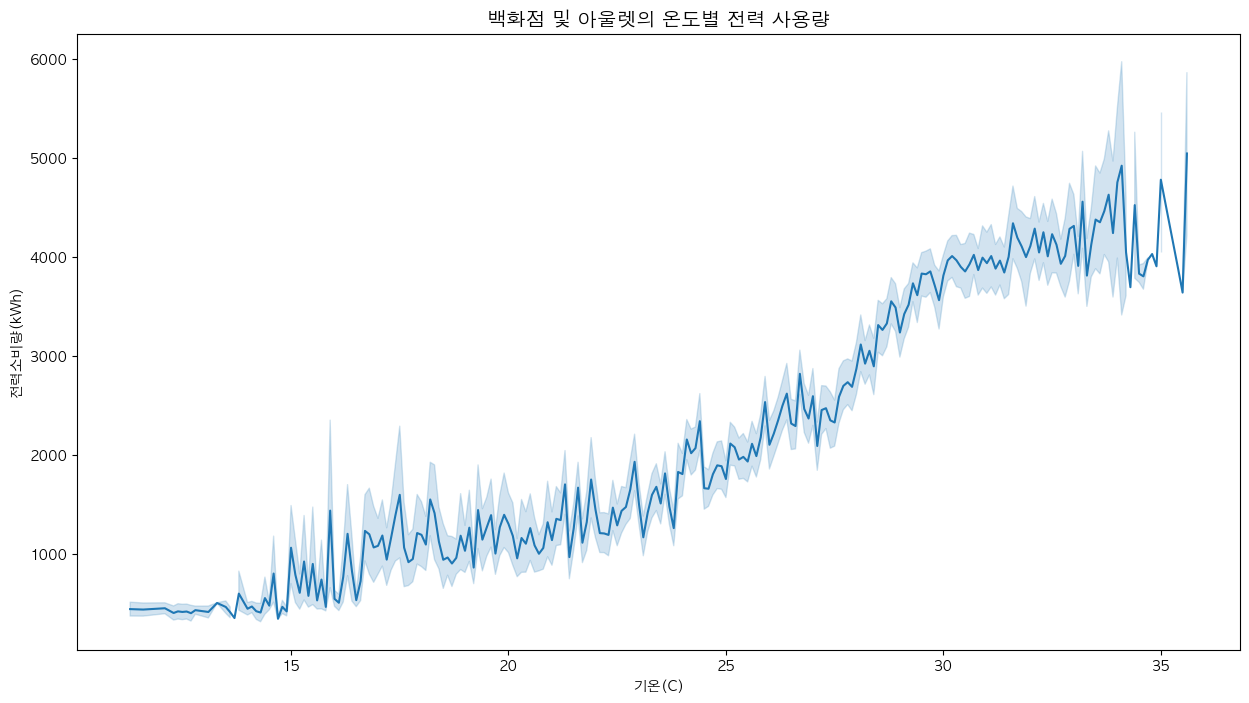

In [471]:
# 백화점 및 아울렛의 온도별 전력 사용량 그래프

dept_outlet_df = train_df[train_df['건물유형'] == '백화점및아울렛']

plt.figure(figsize=(15,8))
plt.title('백화점 및 아울렛의 온도별 전력 사용량', fontsize=14)
sns.lineplot(x='기온(C)', y='전력소비량(kWh)', data=dept_outlet_df)
plt.show()

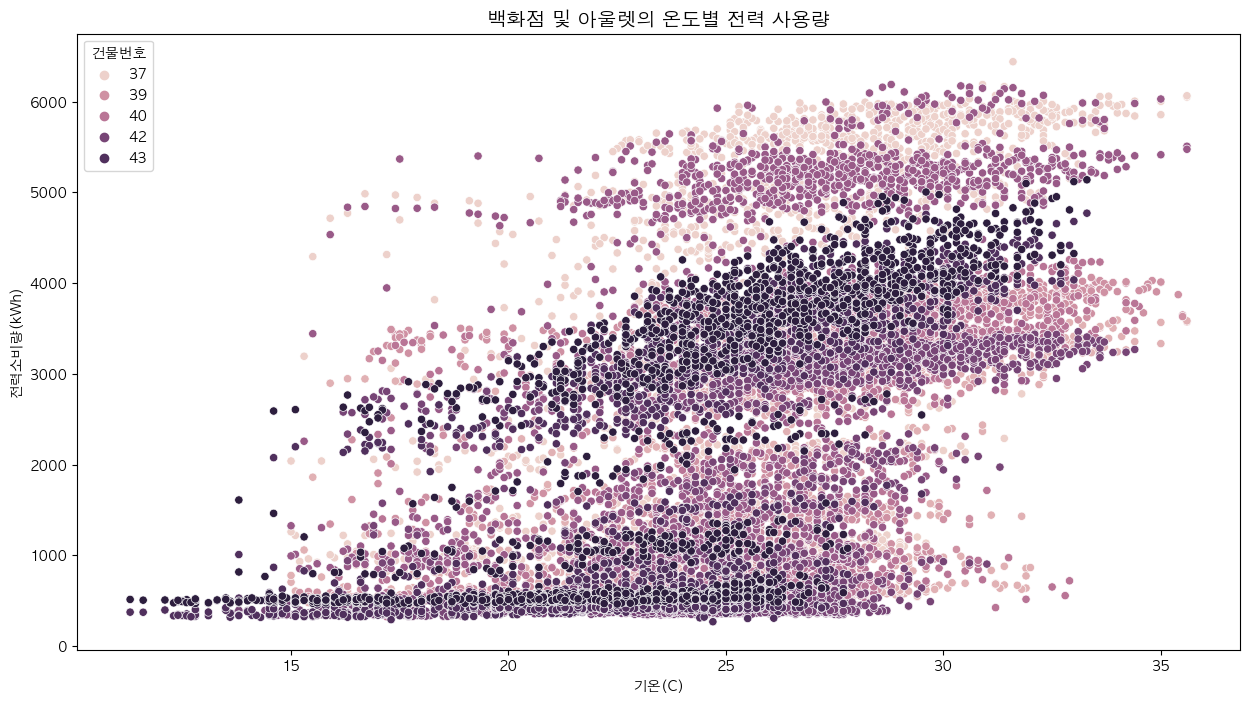

In [472]:
# 백화점 및 아울렛의 온도별 전력 사용량 그래프

dept_outlet_df = train_df[train_df['건물유형'] == '백화점및아울렛']

plt.figure(figsize=(15,8))
plt.title('백화점 및 아울렛의 온도별 전력 사용량', fontsize=14)
sns.scatterplot(x='기온(C)', y='전력소비량(kWh)', hue='건물번호', data=dept_outlet_df)
plt.show()

### 분석결과 : '백화점 및 아울렛' 유형과 '할인마트' 유형이 온도가 올라갈 수록 전기사용량이 뚜렷하게 증가함

## 레이블 작업 하기

In [473]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   건물번호          204000 non-null  int64         
 1   일시            204000 non-null  datetime64[ns]
 2   기온(C)         204000 non-null  float64       
 3   강수량(mm)       204000 non-null  float64       
 4   풍속(m/s)       204000 non-null  float64       
 5   습도(%)         204000 non-null  float64       
 6   일조(hr)        204000 non-null  float64       
 7   일사(MJ/m2)     204000 non-null  float64       
 8   전력소비량(kWh)    204000 non-null  float64       
 9   YEAR          204000 non-null  int32         
 10  MONTH         204000 non-null  int32         
 11  DAY           204000 non-null  int32         
 12  DATE          204000 non-null  object        
 13  HOUR          204000 non-null  int32         
 14  WEEKDAY       204000 non-null  int32         
 15  DI            204

In [474]:
# 레이블링 작업
le = LabelEncoder()
train_df['건물유형'] = le.fit_transform(train_df['건물유형'])

In [475]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   건물번호          204000 non-null  int64         
 1   일시            204000 non-null  datetime64[ns]
 2   기온(C)         204000 non-null  float64       
 3   강수량(mm)       204000 non-null  float64       
 4   풍속(m/s)       204000 non-null  float64       
 5   습도(%)         204000 non-null  float64       
 6   일조(hr)        204000 non-null  float64       
 7   일사(MJ/m2)     204000 non-null  float64       
 8   전력소비량(kWh)    204000 non-null  float64       
 9   YEAR          204000 non-null  int32         
 10  MONTH         204000 non-null  int32         
 11  DAY           204000 non-null  int32         
 12  DATE          204000 non-null  object        
 13  HOUR          204000 non-null  int32         
 14  WEEKDAY       204000 non-null  int32         
 15  DI            204

In [479]:
# 컬럼 삭제
train_df.drop(['일시', 'DATE'], axis=1, inplace=True)

## 모델 선정하기

### cross val score 로 모델 선정하기

In [481]:
x_train = train_df.drop(['전력소비량(kWh)'], axis=1)
y_train = train_df['전력소비량(kWh)']

In [482]:
# 성능 지표, 교차 검증 세트
# neg_mean_absolute_error, neg_mean_squared_error, neg_root_mean_squared_error
score_param = 'neg_root_mean_squared_error'
cv_param = 5
round_param = 4

model = LinearRegression(n_jobs=-1)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-28925.7667  -4832.2838  -1260.1199  -1595.839    -988.3272]
평균 검증 정확도: -7520.4673


In [483]:
model = SGDRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-6.62110066e+19 -5.95124897e+20 -3.49540478e+20 -5.44100967e+20
 -5.77957300e+18]
평균 검증 정확도: -3.121513841797723e+20


In [484]:
model = ARDRegression()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-28987.6618  -4832.7102  -1255.2374  -1559.367    -944.6062]
평균 검증 정확도: -7515.9165


In [485]:
model = RandomForestRegressor(n_jobs=-1)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1594.1156 -4392.1925 -1682.1568 -3980.3899 -2219.31  ]
평균 검증 정확도: -2773.633


In [486]:
model = GradientBoostingRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1815.2427 -4564.8187 -1465.8506 -3583.5325 -1083.1438]
평균 검증 정확도: -2502.5177


In [487]:
model = BaggingRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1678.0527 -4391.3216 -1642.9136 -3945.2624 -2241.4605]
평균 검증 정확도: -2779.8022


### 검증 결과 : 아래의 3가지가 성능이 좋게 나옴
- RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor

### 그 중에 RandomForestRegressor를 사용할 예정임

### train test 분리

In [488]:
x_train, x_test, y_train, y_test = train_test_split(train_df.drop(['전력소비량(kWh)'], axis=1), train_df['전력소비량(kWh)'], test_size=0.2, random_state=123)

### 모델별 성능 확인을 위한 함수

In [489]:
my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

### LinearRegression

In [ ]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(x_train, y_train)
pred = linear_reg.predict(x_test)
print(linear_reg.coef_)
print(linear_reg.intercept_)

In [ ]:
mse_eval('LinearRegression', pred, y_test)

In [ ]:
# 값이 커질 수록 큰 규제입니다.
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

In [ ]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)
    pred = ridge.predict(x_test)
    mse_eval('Ridge(alpha={})'.format(alpha), pred, y_test)

In [ ]:
ridge.coef_

In [ ]:
# ridge 의 alpha 값 1을 적용
ridge = Ridge(alpha=1)
ridge_pred = ridge.fit(x_train,y_train).predict(x_test)

In [ ]:
# 값이 커질 수록 큰 규제입니다.
# alpha값이 커질수록 직선에 가까워진다.
alphas = [1, 0.1, 0.01, 0.001, 0.0001]

In [ ]:
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    pred = lasso.predict(x_test)
    mse_eval('Lasso(alpha={})'.format(alpha), pred, y_test)

In [ ]:
# Lasso에 alpha 값 0.1을 적용
lasso = Lasso(alpha=0.1)
lasso_pred = lasso.fit(x_train, y_train).predict(x_test)

In [ ]:
# ratios가 수식의 r이다.
ratios = [0.2, 0.5, 0.8]

In [ ]:
for ratio in ratios:
    elasticnet = ElasticNet(alpha=0.5, l1_ratio=ratio)
    elasticnet.fit(x_train, y_train)
    pred = elasticnet.predict(x_test)
    mse_eval('ElasticNet(l1_ratio={})'.format(ratio), pred, y_test)

In [ ]:
# ElasticNet에 Ration 0.8 적용
elasticnet = ElasticNet(alpha=0.5, l1_ratio=0.8)
elasticnet_pred = elasticnet.fit(x_train, y_train).predict(x_test)

In [ ]:
std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(x_train)
round(pd.DataFrame(std_scaled).describe(), 2)

In [ ]:
minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(x_train)
round(pd.DataFrame(minmax_scaled).describe(), 2)

In [ ]:
robust_scaler = RobustScaler()
robust_scaled = robust_scaler.fit_transform(x_train)
round(pd.DataFrame(robust_scaled).median(), 2)

In [ ]:
elasticnet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)

In [ ]:
elasticnet_pipeline.fit(x_train, y_train)
pred = elasticnet_pipeline.predict(x_test)
mse_eval('Standard ElasticNet', pred, y_test)

In [ ]:
elasticnet_no_pipeline = ElasticNet(alpha=0.1, l1_ratio=0.2)
no_pipelline_pred = elasticnet_no_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('No Standard ElasticNet', no_pipelline_pred, y_test)

### Polynomial Features

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x_train)[0]
## 질문 왜 [0] ##

In [ ]:
poly_features

In [ ]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)

In [ ]:
poly_pred = poly_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Poly ElasticNet', poly_pred, y_test)

### 보팅(Voting)

In [ ]:
single_models =[
    ('linear_reg', linear_reg),
    ('ridge', ridge),
    ('lasso', lasso),
    ('elasticnet_pipeline', elasticnet_pipeline),
    ('poly_pipeline', poly_pipeline)
]

In [ ]:
voting_regressor = VotingRegressor(single_models, n_jobs=-1)
voting_regressor.fit(x_train, y_train)
voting_pred = voting_regressor.predict(x_test)
mse_eval('Voting Ensemble', voting_pred, y_test)

## Regression Model Fit

In [ ]:
model = RandomForestRegressor()
model.fit(train_x, train_y)

## Test Data Pre-Processing

In [ ]:
test_df['month'] = test_df['일시'].apply(lambda x : int(x[4:6]))
test_df['day'] = test_df['일시'].apply(lambda x : int(x[6:8]))
test_df['time'] = test_df['일시'].apply(lambda x : int(x[9:11]))

In [ ]:
test_x = test_df.drop(columns=['num_date_time', '일시'])

## Inference

In [ ]:
preds = model.predict(test_x)